In [34]:
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
import string
import random
import scipy
from scipy import signal
from sklearn.decomposition import FastICA, PCA

from matplotlib import *
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
%matplotlib inline
"""
http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html
http://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_vs_pca.html#sphx-glr-auto-examples-decomposition-plot-ica-vs-pca-py
"""
N = 1000
alphabet = string.ascii_lowercase + '#' + '.'
D = len(alphabet)
z = np.ones(N)

RI_pres = np.random.rand(D, N)
RI_pres = np.where(RI_pres>0.5, 1, -1)

RI_past = np.random.rand(D, N)
RI_past = np.where(RI_past>0.5, 1, -1)

def read_csv(filepath):
    category2word = {}
    key = 0
    present, past = [], []
    num_words = 0
    with open(filepath, 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            if row[0] == "#":
                category2word[key] = [present, past]
                key += 1;
                present, past = [], []
            else:
                present.append(row[0])
                past.append(row[1])
            num_words += 1
    return category2word, num_words

def ngram_encode_cl(ngram_str, letter_vecs, window=3):
    vec = np.zeros(letter_vecs.shape[1])
    full_str = '#' + ngram_str + '.'
    for il, l in enumerate(full_str[:-(window-1)]):
        trivec = letter_vecs[alphabet.find(full_str[il]), :]
        for c3 in range(1, window):
            trivec = trivec * np.roll(letter_vecs[alphabet.find(full_str[il+c3]), :], c3)     
        vec += trivec
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) < 0) - 1

def plot_samples(S, axis_list=None):
    plt.scatter(S[:, 0], S[:, 1], s=2, marker='o', zorder=10,
                color='steelblue', alpha=0.5)
    if axis_list is not None:
        colors = ['orange', 'red']
        for color, axis in zip(colors, axis_list):
            axis /= axis.std()
            x_axis, y_axis = axis
            # Trick to get legend to work
            plt.plot(0.1 * x_axis, 0.1 * y_axis, linewidth=2, color=color)
            plt.quiver(0, 0, x_axis, y_axis, zorder=11, width=0.01, scale=6,
                       color=color)

In [35]:
category2word, num_words = read_csv("data/cleaned/irregular_verbs_final_categorize.csv")

In [74]:
print category2word[0]
# compressed, cat1 is so similar that the variance was ~ 0
print category2word[1]

[['beat', 'fit', 'set', 'spread', 'hit', 'cut', 'put', 'thrust', 'bid'], ['beaten', 'fit', 'set', 'spread', 'hit', 'cut', 'put', 'thrust', 'bid']]
[['build', 'send', 'spend', 'bend', 'lend'], ['built', 'sent', 'spent', 'bent', 'lent']]


In [36]:
available_colors = ['green', 'red', 'blue', 'yellow', 'black']
# looking only at category 0, 1
selected_categories = [0, 1]
num_diffs = 0
past = []
for c in selected_categories:
    num_diffs += len(category2word[c][0])
    past += category2word[c][1]
data_matrix = np.zeros((num_diffs, N))
ngram_lengths = [2, 3, 4]

ngram_length 2


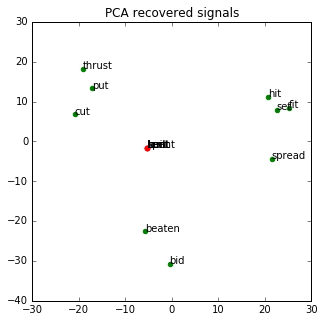

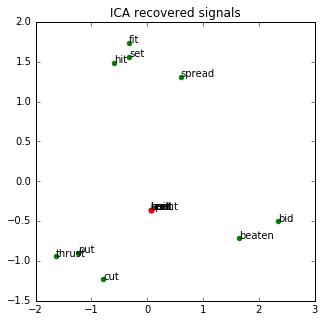

ngram_length 3


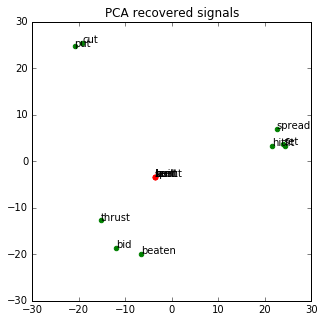

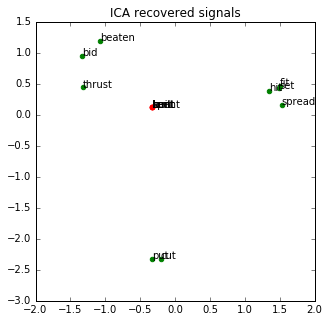

ngram_length 4


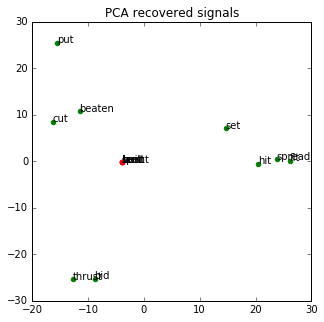

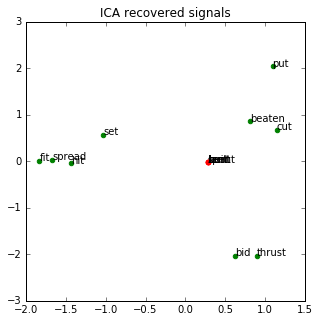

In [79]:
for ngram_length in ngram_lengths:
    print "ngram_length %d" % ngram_length
    # Generate observations
    for c in selected_categories:
        num_subwords = len(category2word[c][0])
        for i in range(num_subwords):
            data_matrix[i] = ngram_encode_cl(category2word[c][1][i], RI_past, ngram_length) - ngram_encode_cl(category2word[c][0][i], RI_pres, ngram_length)
    """
    # isn't our data already noisy tho? try mixing first?
    # Mix data
    A = np.random.random(data_matrix.shape) # Mixing matrix
    X = np.dot(data_matrix, A.T)  # Generate observations
    """
    X = data_matrix

    pca = PCA(n_components=2)
    S_pca_ = pca.fit(X).transform(X)

    ica = FastICA(n_components=2)
    S_ica_ = ica.fit(X).transform(X)  # Estimate the sources

    S_ica_ /= S_ica_.std(axis=0)
    
    axis_list = [pca.components_.T, ica.mixing_]
    
    # 2d
    fig, ax = plt.subplots(figsize=(5,5))
    i = 0
    for c in selected_categories:
        for txt in category2word[c][1]:
            ax.annotate(txt, S_pca_[i])
            ax.scatter(S_pca_[i][0], S_pca_[i][1], color=available_colors[c])
            i += 1
    plt.title('PCA recovered signals')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(5,5))
    i = 0
    for c in selected_categories:
        for txt in category2word[c][1]:
            ax.annotate(txt, S_ica_[i])
            ax.scatter(S_ica_[i][0], S_ica_[i][1], color=available_colors[c])
            i += 1
    plt.title('ICA recovered signals')
    plt.show()
    
    """
    plt.subplot(2, 2, 3)
    cat = S_pca_[:len(category2word[0][0])] #/ np.std(S_pca_[:len(category2word[0][0])], axis=0)
    cat1 = S_pca_[len(category2word[0][0]):] #/ np.std(S_pca_[len(category2word[0][0]):], axis=0)
    #print np.std(S_pca_[:len(category2word[0][0])], axis=0)
    plt.scatter(cat[:,0], cat[:,1], color="red")
    plt.scatter(cat1[:,0], cat1[:,1], color="blue")
    plt.title('PCA recovered signals')
    
    plt.subplot(2, 2, 4)
    cat = S_ica_[:len(category2word[0][0])] #/ np.std(S_ica_[:len(category2word[0][0])], axis=0)
    cat1 = S_ica_[len(category2word[0][0]):] #/ np.std(S_ica_[len(category2word[0][0]):], axis=0)
    
    plt.scatter(cat[:,0], cat[:,1], color="red")
    plt.scatter(cat1[:,0], cat1[:,1], color="blue")
    plt.title('ICA recovered signals')

    plt.show()
    """
    

    


(20000, 2)
(20000, 2)


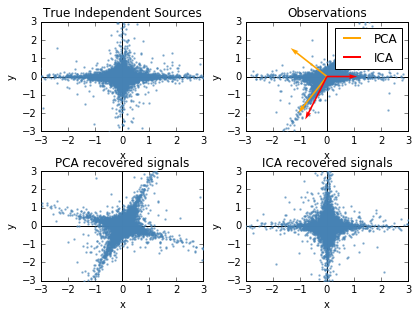

In [30]:
rng = np.random.RandomState(42)
print rng
S = rng.standard_t(1.5, size=(20000, 2))
S[:, 0] *= 2.
print S.shape
# Mix data
A = np.array([[1, 1], [0, 2]])  # Mixing matrix

X = np.dot(S, A.T)  # Generate observations
print X.shape
pca = PCA()
S_pca_ = pca.fit(X).transform(X)

ica = FastICA(random_state=rng)
S_ica_ = ica.fit(X).transform(X)  # Estimate the sources

S_ica_ /= S_ica_.std(axis=0)

def plot_samples(S, axis_list=None):
    plt.scatter(S[:, 0], S[:, 1], s=2, marker='o', zorder=10,
                color='steelblue', alpha=0.5)
    if axis_list is not None:
        colors = ['orange', 'red']
        for color, axis in zip(colors, axis_list):
            axis /= axis.std()
            x_axis, y_axis = axis
            # Trick to get legend to work
            plt.plot(0.1 * x_axis, 0.1 * y_axis, linewidth=2, color=color)
            plt.quiver(0, 0, x_axis, y_axis, zorder=11, width=0.01, scale=6,
                       color=color)

    plt.hlines(0, -3, 3)
    plt.vlines(0, -3, 3)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.xlabel('x')
    plt.ylabel('y')

plt.figure()
plt.subplot(2, 2, 1)
plot_samples(S / S.std())
plt.title('True Independent Sources')

axis_list = [pca.components_.T, ica.mixing_]
plt.subplot(2, 2, 2)
plot_samples(X / np.std(X), axis_list=axis_list)
legend = plt.legend(['PCA', 'ICA'], loc='upper right')
legend.set_zorder(100)

plt.title('Observations')

plt.subplot(2, 2, 3)
plot_samples(S_pca_ / np.std(S_pca_, axis=0))
plt.title('PCA recovered signals')

plt.subplot(2, 2, 4)
plot_samples(S_ica_ / np.std(S_ica_))
plt.title('ICA recovered signals')

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.36)
plt.show()

Automatically created module for IPython interactive environment


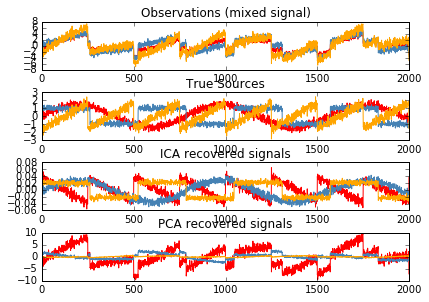

In [2]:
print(__doc__)

import numpy as np


from scipy import signal

from sklearn.decomposition import FastICA, PCA

import matplotlib.pyplot as plt
%matplotlib inline

###############################################################################
# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

###############################################################################
# Plot results

plt.figure()

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals', 
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
plt.show()
